In [2]:
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import ccf_streamlines.projection as ccfproj
from datasets import load_from_disk
import yaml
from scipy import stats


from typing import Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys

# import ../utils

sys.path.append('../')

from utils import reflect_points_to_left, generate_distinct_colors

from colormycells import get_colormap



In [3]:
root_path = os.environ["ROOT_DATA_PATH"]
ccf_files_path = os.path.join(root_path, "CCF_files")



In [4]:

space = "flatmap_butterfly"
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=    os.path.join(ccf_files_path,f"{space}.nrrd"),
    labels_file=    os.path.join(ccf_files_path,"labelDescription_ITKSNAPColor.txt"),
)
bf_left_boundaries_flat = bf_boundary_finder.region_boundaries()


# move up the hierarchy to get rid of the smallest 'areas' which are actually layers
with open('../../data/files/area_ancestor_id_map.json', 'r') as f:
    area_ancestor_id_map = json.load(f)
with open('../../data/files/area_name_map.json', 'r') as f:
    area_name_map = json.load(f)
area_name_map['0'] = 'outside_brain'
annotation2area_int = {0.0:0} # Map from annotation id to area id. Float to int
for a in area_ancestor_id_map.keys(): 
    higher_area_id = area_ancestor_id_map[str(int(a))][1] if len(area_ancestor_id_map[str(int(a))])>1 else a    
    annotation2area_int[float(a)] = higher_area_id

unique_areas = np.unique(list(annotation2area_int.values())) # List of unique areas (noncontiguous ints)
unique_annos = [area_name_map[str(int(a))] for a in unique_areas] # List of unique area names
area_classes = np.arange(len(unique_areas)) # Create a class for each area (0, 1, 2, ...)
id2id = {float(k):v for (k,v) in zip(unique_areas, area_classes)} # Map from area id to class id
annoation2area_class = {k: id2id[int(v)] for k,v in annotation2area_int.items()} # Map from annotation to area class
id2id_rev = {v:k for k,v in id2id.items()} # Map from class id to area id
area_class2area_name = {k: area_name_map[str(int(v))] for k,v in id2id_rev.items()} # Map from area class to area name




In [5]:
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=    os.path.join(ccf_files_path,"flatmap_butterfly.nrrd"),
    labels_file=    os.path.join(ccf_files_path,"labelDescription_ITKSNAPColor.txt"),
)

bf_left_boundaries_flat = bf_boundary_finder.region_boundaries()
bf_right_boundaries_flat = bf_boundary_finder.region_boundaries(
    hemisphere='right_for_both',
    view_space_for_other_hemisphere='flatmap_butterfly',
)

In [6]:
animals = ["filt_neurons_D076_1L_CCFv2_newtypes.h5ad",
    "filt_neurons_D077_1L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D077_2L_CCFv2_newtypes.h5ad",
    "filt_neurons_D078_1L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D078_2L_CCFv2_newtypes.h5ad",
    "filt_neurons_D079_3L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D079_4L_CCFv2_newtypes.h5ad"
    ]


In [7]:
ann_path = "../../data/anndatas"
ann_files = [ad.read_h5ad(os.path.join(ann_path, f)) for f in animals]

for i, adata in enumerate(ann_files):
    subcortical_mask = np.isnan(adata.obsm['CCF_streamlines']).any(axis=1)
    adata = adata[~subcortical_mask]


    adata.obs['area_label'] = adata.obs['CCFano'].map(annoation2area_class).astype('category')
    adata.obs['area_name'] = adata.obs['area_label'].map(area_class2area_name).astype('category')

    nonzero_counts_mask = np.sum(adata.X, axis=1) > 10
    adata = adata[nonzero_counts_mask]
    ann_files[i] = adata
    
ann_files[0]

/tmp/ipykernel_1163091/443668951.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['area_label'] = adata.obs['CCFano'].map(annoation2area_class).astype('category')
/tmp/ipykernel_1163091/443668951.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['area_label'] = adata.obs['CCFano'].map(annoation2area_class).astype('category')
/tmp/ipykernel_1163091/443668951.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['area_label'] = adata.obs['CCFano'].map(annoation2area_class).astype('category')
/tmp/ipykernel_1163091/443668951.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['area_label'] = adata.obs['CCFano'].map(annoation2area_class).astype('category')


View of AnnData object with n_obs × n_vars = 388342 × 106
    obs: 'angle', 'H1_type', 'CCFname', 'slice', 'CCFparentname', 'id', 'H2_type', 'CCFano', 'H3_type', 'area_label', 'area_name'
    uns: 'H2_type_id', 'H3_type_id', 'brain_idx', 'genes', 'slices_to_remove'
    obsm: 'CCF', 'CCF_streamlines', 'depth', 'pos', 'pos40x'

## Look at gene distributions

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.colors import PowerNorm
import warnings

# Example usage:
# fig, ax = plot_spatial_gene_density(adata, gene_idx=0)  # Plot first gene
# fig, ax = plot_spatial_gene_density(adata, gene_idx=100, normalize_by_cell_density=True)
# 
# # To find a specific gene's index:
# gene_name = "Sox2"
# gene_idx = list(adata.uns['genes']).index(gene_name)
# fig, ax = plot_spatial_gene_density(adata, gene_idx)
#
# # Note: vmin/vmax parameters only work with 'hexbin' method and normalized 'kde'
# fig, ax = plot_spatial_gene_density(adata, gene_idx=0, method='hexbin', vmin=0, vmax=10)

def plot_spatial_gene_density(adata, gene_idx, normalize_by_cell_density=False, 
                              method='kde', figsize=(10, 8), cmap='viridis',
                              kde_levels=50, hexbin_gridsize=50, 
                              vmin=None, vmax=None, title=None):
    """
    Plot spatial density of gene expression from anndata object.
    
    Parameters
    ----------
    adata : AnnData
        Annotated data matrix with spatial coordinates in obsm['CCF_streamlines']
    gene_idx : int
        Column index of the gene to plot. Gene name will be retrieved from adata.uns['genes'][gene_idx]
    normalize_by_cell_density : bool, default False
        Whether to normalize gene density by overall cell density
    method : str, default 'kde'
        Plotting method: 'kde', 'hexbin', or 'scatter'
    figsize : tuple, default (10, 8)
        Figure size
    cmap : str, default 'viridis'
        Colormap for density visualization
    kde_levels : int, default 50
        Number of contour levels for KDE plot
    hexbin_gridsize : int, default 50
        Grid size for hexbin plot
    vmin, vmax : float, optional
        Min and max values for color scale (only supported for 'hexbin' and normalized 'kde' methods)
    title : str, optional
        Custom title for the plot
    
    Returns
    -------
    fig, ax : matplotlib figure and axis objects
    """
    
    # Get gene name from index
    if not isinstance(gene_idx, int):
        raise TypeError(f"gene_idx must be an integer, got {type(gene_idx)}")
    
    if gene_idx < 0 or gene_idx >= adata.n_vars:
        raise ValueError(f"gene_idx {gene_idx} out of range. Must be between 0 and {adata.n_vars-1}")
    
    gene_name = adata.uns['genes'][gene_idx]
    
    # Extract spatial coordinates (first 2 columns)
    coords = adata.obsm['CCF_streamlines'][:, :2]
    x_coords = coords[:, 0]
    y_coords = coords[:, 1]
    
    # Get gene expression values
    expression = adata.X[:, gene_idx]
    
    # Handle sparse matrices
    if hasattr(expression, 'toarray'):
        expression = expression.toarray().flatten()
    else:
        expression = np.asarray(expression).flatten()
    
    # Filter out zero expression cells for cleaner visualization
    nonzero_mask = expression > 0
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    if method == 'kde':
        if normalize_by_cell_density:
            # Calculate cell density KDE
            cell_kde = gaussian_kde(coords.T)
            
            # Calculate gene expression weighted KDE
            # Weight each point by its expression value
            weights = expression / expression.sum() if expression.sum() > 0 else expression
            gene_kde = gaussian_kde(coords.T, weights=weights)
            
            # Create grid for evaluation
            x_min, x_max = x_coords.min(), x_coords.max()
            y_min, y_max = y_coords.min(), y_coords.max()
            
            xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
            positions = np.vstack([xx.ravel(), yy.ravel()])
            
            # Evaluate KDEs
            cell_density = cell_kde(positions).reshape(xx.shape)
            gene_density = gene_kde(positions).reshape(xx.shape)
            
            # Normalize: avoid division by zero
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                normalized_density = np.divide(gene_density, cell_density, 
                                             out=np.zeros_like(gene_density), 
                                             where=cell_density > 0)
            
            # Plot normalized density
            contour_kwargs = {'levels': kde_levels, 'cmap': cmap}
            if vmin is not None:
                contour_kwargs['vmin'] = vmin
            if vmax is not None:
                contour_kwargs['vmax'] = vmax
            
            contour = ax.contourf(xx, yy, normalized_density, **contour_kwargs)
            cbar_label = 'Normalized Expression Density'
        else:
            # Plot gene expression density for expressing cells only
            if nonzero_mask.sum() > 0:
                # Note: seaborn kdeplot doesn't support vmin/vmax
                sns.kdeplot(x=x_coords[nonzero_mask], y=y_coords[nonzero_mask], 
                           weights=expression[nonzero_mask], 
                           fill=True, levels=kde_levels, cmap=cmap,
                           ax=ax)
                cbar_label = 'Expression Density'
            else:
                ax.text(0.5, 0.5, 'No expression detected', 
                       transform=ax.transAxes, ha='center', va='center')
    
    elif method == 'hexbin':
        if normalize_by_cell_density:
            # Create hexbin for all cells (cell density)
            cell_hexbin = ax.hexbin(x_coords, y_coords, gridsize=hexbin_gridsize,
                                   reduce_C_function=np.sum, mincnt=1)
            cell_counts = cell_hexbin.get_array()
            
            # Create hexbin for gene expression
            gene_hexbin = ax.hexbin(x_coords, y_coords, C=expression, 
                                   gridsize=hexbin_gridsize, reduce_C_function=np.sum,
                                   mincnt=0)
            gene_sums = gene_hexbin.get_array()
            
            # Normalize
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                normalized_values = np.divide(gene_sums, cell_counts, 
                                            out=np.zeros_like(gene_sums), 
                                            where=cell_counts > 0)
            
            # Update the hexbin with normalized values
            gene_hexbin.set_array(normalized_values)
            
            # Add colorbar
            cbar = plt.colorbar(gene_hexbin, ax=ax)
            cbar_label = 'Mean Expression per Cell'
        else:
            # Plot gene expression sum per hexbin
            hexbin_kwargs = {
                'gridsize': hexbin_gridsize,
                'cmap': cmap,
                'reduce_C_function': np.sum,
                'mincnt': 0
            }
            if vmin is not None:
                hexbin_kwargs['vmin'] = vmin
            if vmax is not None:
                hexbin_kwargs['vmax'] = vmax
                
            hexbin = ax.hexbin(x_coords, y_coords, C=expression, **hexbin_kwargs)
            cbar = plt.colorbar(hexbin, ax=ax)
            cbar_label = 'Total Expression'
    
    elif method == 'scatter':
        # Simple scatter plot with expression as color
        if normalize_by_cell_density:
            # For scatter plots, we can't easily normalize by density
            # So we'll just show expression values
            print("Note: Cell density normalization not implemented for scatter plots")
        
        # Plot only expressing cells
        if nonzero_mask.sum() > 0:
            scatter_kwargs = {
                'c': expression[nonzero_mask],
                'cmap': cmap,
                's': 1,
                'alpha': 0.5
            }
            if vmin is not None:
                scatter_kwargs['vmin'] = vmin
            if vmax is not None:
                scatter_kwargs['vmax'] = vmax
                
            scatter = ax.scatter(x_coords[nonzero_mask], y_coords[nonzero_mask], 
                               **scatter_kwargs)
            cbar = plt.colorbar(scatter, ax=ax)
            cbar_label = 'Expression Level'
        else:
            ax.text(0.5, 0.5, 'No expression detected', 
                   transform=ax.transAxes, ha='center', va='center')
    
    else:
        raise ValueError(f"Method '{method}' not recognized. Use 'kde', 'hexbin', or 'scatter'")
    
    # Customize plot
    ax.set_xlabel('CCF X coordinate')
    ax.set_ylabel('CCF Y coordinate')
    
    if title is None:
        norm_text = " (normalized by cell density)" if normalize_by_cell_density else ""
        title = f'{gene_name} Expression Density{norm_text}'
    ax.set_title(title)
    
    # Add colorbar label if colorbar exists
    if 'cbar' in locals():
        cbar.set_label(cbar_label)
    elif method == 'kde' and not normalize_by_cell_density and nonzero_mask.sum() > 0:
        # For seaborn kde plots, we need to add colorbar manually
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label(cbar_label)
    
    # Set aspect ratio to equal for spatial data
    ax.set_aspect('equal', adjustable='box')
    
    # Add statistics to plot
    n_expressing = nonzero_mask.sum()
    pct_expressing = 100 * n_expressing / len(expression)
    stats_text = f'Expressing cells: {n_expressing:,} ({pct_expressing:.1f}%)'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', 
            facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig, ax


# Example usage function
def plot_multiple_genes(adata, gene_indices, normalize=False, method='kde', 
                       ncols=3, figsize_per_plot=(6, 5)):
    """
    Plot spatial density for multiple genes in a grid.
    
    Parameters
    ----------
    adata : AnnData
        Annotated data matrix
    gene_indices : list of int
        List of gene column indices to plot
    normalize : bool
        Whether to normalize by cell density
    method : str
        Plotting method ('kde', 'hexbin', or 'scatter')
    ncols : int
        Number of columns in the grid
    figsize_per_plot : tuple
        Size of each subplot
    """
    n_genes = len(gene_indices)
    nrows = int(np.ceil(n_genes / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, 
                            figsize=(figsize_per_plot[0] * ncols, 
                                   figsize_per_plot[1] * nrows))
    
    if nrows == 1 and ncols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, gene_idx in enumerate(gene_indices):
        try:
            # Get gene name for display
            gene_name = adata.uns['genes'][gene_idx]
            
            # Extract data
            coords = adata.obsm['CCF_streamlines'][:, :2]
            x_coords = coords[:, 0]
            y_coords = coords[:, 1]
            expression = adata.X[:, gene_idx]
            
            if hasattr(expression, 'toarray'):
                expression = expression.toarray().flatten()
            else:
                expression = np.asarray(expression).flatten()
            
            nonzero_mask = expression > 0
            
            # Plot based on method
            if method == 'kde' and nonzero_mask.sum() > 0:
                if normalize:
                    # Calculate normalized density
                    cell_kde = gaussian_kde(coords.T)
                    weights = expression / expression.sum() if expression.sum() > 0 else expression
                    gene_kde = gaussian_kde(coords.T, weights=weights)
                    
                    x_min, x_max = x_coords.min(), x_coords.max()
                    y_min, y_max = y_coords.min(), y_coords.max()
                    
                    xx, yy = np.mgrid[x_min:x_max:50j, y_min:y_max:50j]
                    positions = np.vstack([xx.ravel(), yy.ravel()])
                    
                    cell_density = cell_kde(positions).reshape(xx.shape)
                    gene_density = gene_kde(positions).reshape(xx.shape)
                    
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        normalized_density = np.divide(gene_density, cell_density, 
                                                     out=np.zeros_like(gene_density), 
                                                     where=cell_density > 0)
                    
                    axes[i].contourf(xx, yy, normalized_density, levels=20, cmap='viridis')
                else:
                    sns.kdeplot(x=x_coords[nonzero_mask], y=y_coords[nonzero_mask], 
                               weights=expression[nonzero_mask], 
                               fill=True, levels=20, cmap='viridis',
                               ax=axes[i])
            elif method == 'hexbin':
                axes[i].hexbin(x_coords, y_coords, C=expression, 
                              gridsize=30, cmap='viridis',
                              reduce_C_function=np.sum, mincnt=0)
            elif method == 'scatter' and nonzero_mask.sum() > 0:
                axes[i].scatter(x_coords[nonzero_mask], y_coords[nonzero_mask], 
                               c=expression[nonzero_mask], cmap='viridis', 
                               s=1, alpha=0.5)
            elif nonzero_mask.sum() == 0:
                axes[i].text(0.5, 0.5, 'No expression detected', 
                            transform=axes[i].transAxes, ha='center', va='center')
            
            # Add title and stats
            axes[i].set_title(f'{gene_name} (idx: {gene_idx})')
            axes[i].set_aspect('equal', adjustable='box')
            
            # Add statistics
            n_expressing = nonzero_mask.sum()
            pct_expressing = 100 * n_expressing / len(expression)
            stats_text = f'{n_expressing:,} ({pct_expressing:.1f}%)'
            axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes, 
                        verticalalignment='top', fontsize=8,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
        except (ValueError, IndexError, KeyError) as e:
            axes[i].text(0.5, 0.5, f'Error: {str(e)}', transform=axes[i].transAxes,
                        ha='center', va='center')
            axes[i].set_title(f'Gene idx {gene_idx} (Error)')
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    return fig, axes

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Calb1 Expression Density'}, xlabel='CCF X coordinate', ylabel='CCF Y coordinate'>)

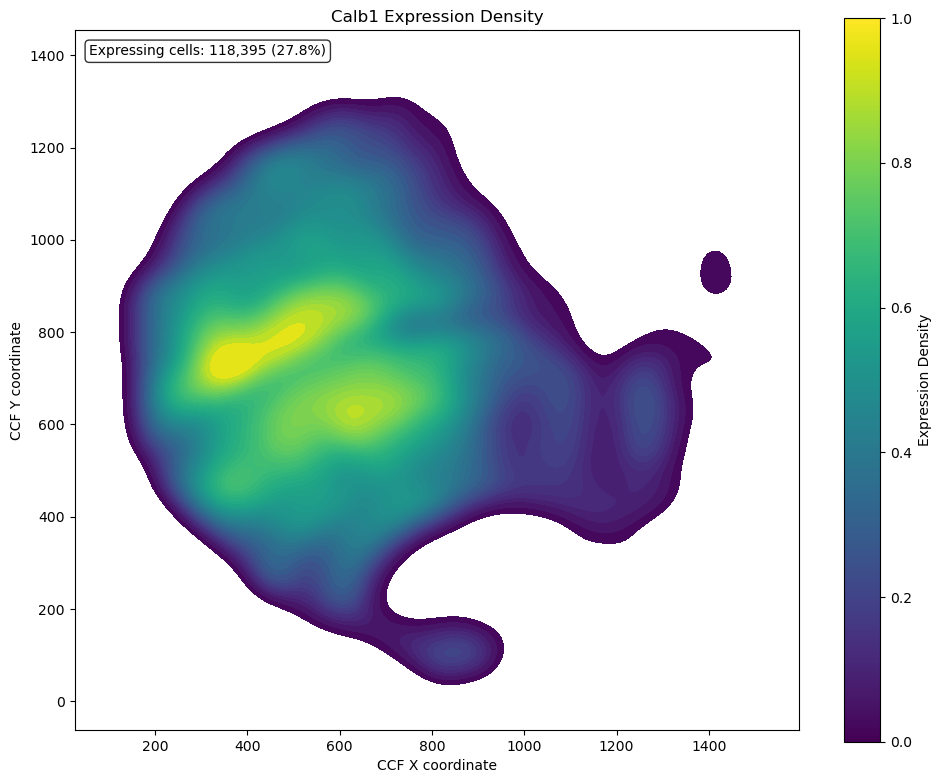

In [21]:
plot_spatial_gene_density(adata, gene_idx=0, method='kde')